# **Understanding Collaborative Filtering via Matrix Decomposition:** from traditional SVD to advanced neural network-based approaches



* Student ID: 20244496
* Student Name: Dongwon Choi

**Note**: All the results were tested on the google colab.

**I highly recommend you to run on the google colab to see figures and to get the similar results!**

---


# 0. Introduction & Background


## Matrix Decomposition (Matrix Factorization)

<center>
<img src="https://drive.google.com/uc?id=14vOSgW8fj6oxWHOxlTpxcTWyez9hN1sG" height=300 width=400>
<br/>
</center>


**Matrix decomposition, also known as matrix factorization**, is a process of breaking down a matrix into simpler, constituent components. These decompositions are fundamental in linear algebra and are widely used in areas like machine learning and data compression.

The key idea of matrix decomposition is to express a matrix $ A $ as the product of two or more matrices with specific properties, making complex operations like solving systems of linear equations, computing eigenvalues, or dimensionality reduction more efficient.

The most popular example of matrix decomposition is the **Singular Value Decomposition (SVD)**, which expresses a matrix $ A $ as:

$A = U \Sigma V^T$

Where:
- $ U $ and $ V $ are orthogonal matrices,
- $ \Sigma $ is a diagonal matrix containing the singular values.


By leveraging these techniques, we can handle high-dimensional data and computational challenges effectively.







## Matirx Decomposition in Recommender Systems

<center>
<img src="https://drive.google.com/uc?id=14xiStBoeX_cDGof9tXIczT3tShy7ABeW" width="400" height="300">
<img src="https://drive.google.com/uc?id=157VpjTf-xNtJlZn6sedfBPnz6GS-eM2I" width="400" height="300">
</center>

In the context of recommender systems, matrix decomposition is widely used to analyze the user-item interaction matrix. For instance, as shown in the figure below, a user-movie rating matrix can be decomposed into three latent matrices by using SVD, **representing users, movies and scaling the interactions between them**. The rank reduction which effectively done by matrix decomposition summarizes users' preferences and movies' characteristics in a compressed form.

**Collaborative filtering** is a core concept tied to this. It leverages interactions (e.g., ratings) between users and items to make predictions. Matrix decomposition plays a key role by enabling us to identify the latent factors that drive user preferences and item characteristics. For example, during **the Netflix Prize Challenge**, SVD-based approaches were pivotal in advancing the accuracy of movie recommendations.

A fundamental assumption in matrix factorization methods like SVD and UV is that the preferences of all users can be represented as a linear combination of a small number of latent vectors. This assumption justifies treating the collaborative filtering as a **low-rank matrix completion task**. Low-rank matrix completion aims to fill in the missing entries of a sparse matrix by leveraging its low-rank structure. This formulation has been instrumental in the design of modern recommendation algorithms and has spurred innovations beyond collaborative filtering.







<center>
<img src="https://drive.google.com/uc?id=1oH54uQVojl7KB1TXSDoqHckk4nJFhcxj" width="300" height="300">
<img src="https://drive.google.com/uc?id=1526cb08HoBX3QCRWg-4RjMBPHorzUHSS" width="600" height="300">
</center>


**In this article, we aim to explore various methods to solve the low-rank matrix completion problem, ranging from traditional SVD to advanced neural network-based approaches. Specifically, we will:**

1. **Implement SVD-based Collaborative Filtering**: Understand how to decompose a matrix and use it for recommendations.

2. **Implement ALS-based Collaborative Filtering**: Utilize an Alternating Lesat Square (ALS) optimization approach to factorize the matrix.

3. **Implement SGD-based Collaborative Filtering**: Utilize an Stochastic Gradient Descent (SGD) optimization approach to factorize the matrix.

4. **Implement Neural Collaborative Filtering (NCF)**: Explore deep learning techniques to model user-item interactions.

This article will help you understand the theoretical foundations and practical implementations of recommender systems!

## Install python packages

(You can skip this if you are in colab now.)

In [ ]:
! pip install fastai matplotlib seaborn numpy pandas scikit-learn
! pip install torch

## Seed fix

In [ ]:
import random
import numpy as np
import torch
from sklearn.utils import check_random_state

def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_global_seed(seed)

## Data prerivew

The **ML_100k dataset (MovieLens 100k)** is a widely used benchmark dataset in the field of recommender systems research. It contains **100,000 ratings** (from 1 to 5) provided by **943 users on 1,682 movies**. The dataset was collected by the **GroupLens Research Project** at the University of Minnesota.

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *

path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Data sparsity visualization

As you can see, not all users rate all movies, creating a sparse matrix typical for real-world recommendation systems.

So, if we make a user-item matrix based on this dataset, **93.70%** of the values are missing values.

Missing value ratio in the User-Movie Rating Matrix: 93.70%


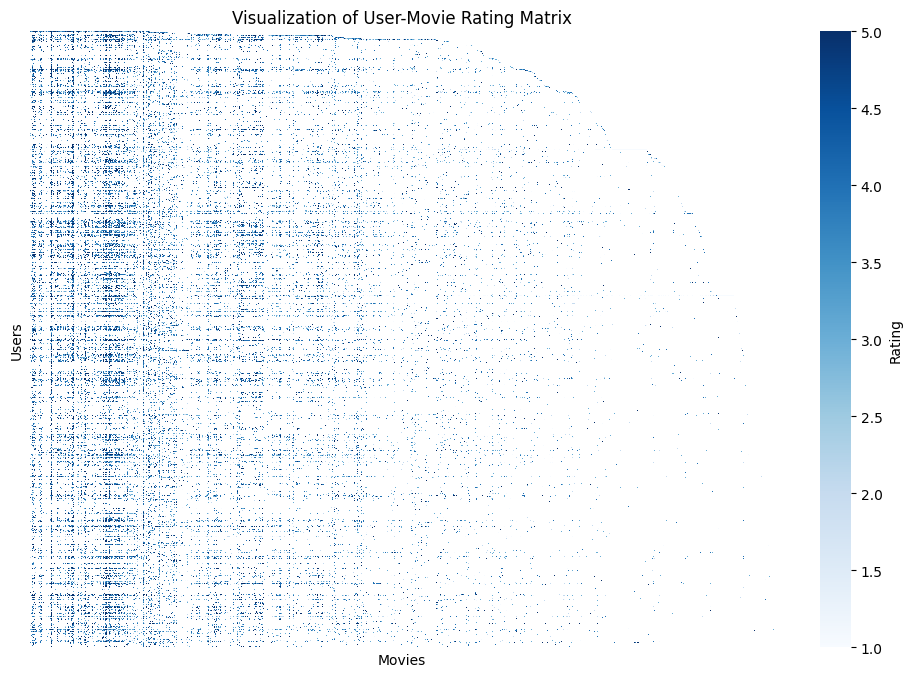

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

user_item_matrix = ratings.pivot(index='user', columns='movie', values='rating')

# calculate missing value ratio
missing_ratio = user_item_matrix.isnull().mean().mean() * 100
print(f"Missing value ratio in the User-Movie Rating Matrix: {missing_ratio:.2f}%")

# visualize sparsity
plt.figure(figsize=(12, 8))
sns.heatmap(user_item_matrix, cmap='Blues', cbar=True, square=False,
            xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Rating'})
plt.title("Visualization of User-Movie Rating Matrix")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

# 1. Implement SVD-based Collaborative Filtering

In this chapter, we will explore the overall workflow of collaborative filtering via implementing a simple form of SVD decomposition. Python's `numpy` library allows for efficient numerical computations, including SVD.

Given the number of factors `k`, the function `compute_svd(matrix, num_factors)` decomposes our rating matrix $ Y $ as follows:

$
Y = U \Sigma I^T
$

Where:
- $ Y $: (U $\times$ M)
- $ U $: (U $\times$ k)
- $ \Sigma $: (k $\times$ k)
- $ I^T $: (k $\times$ M)

Missing values were filed to 0 to perform matrix decomposition.

To ensure a consistent evaluation of all methods presented later, we will train using only 80% of the ratings, while the remaining 20% will serve as the test set for evaluation. The metrics used for evaluation are **Root Mean Square Error (RMSE)** and **Mean Absolute Error (MAE)**.

To understand the impact of the number of factors on the performance of matrix decomposition, we varied the value of k as 5, 10, 20, and 50, observing the corresponding results.

**By executing the cell below, you can view the results of SVD for each value of k.**


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
filled_matrix = ratings.pivot(index='user', columns='movie', values='rating').fillna(0).values

def compute_svd(matrix, num_factors):
    U, sigma, Vt = np.linalg.svd(matrix, full_matrices=False)
    sigma = np.diag(sigma[:num_factors])
    U = U[:, :num_factors]
    Vt = Vt[:num_factors, :]
    return U, sigma, Vt

def train_test_split(ratings, test_size=0.2):
    test_indices = []
    for user in ratings['user'].unique():
        user_data = ratings[ratings['user'] == user]
        test_indices.extend(user_data.sample(frac=test_size, random_state=42).index)
    test_set = ratings.loc[test_indices]
    train_set = ratings.drop(test_indices)
    return train_set, test_set

train_ratings, test_ratings = train_test_split(ratings, test_size=0.2)

k_values = [5, 10, 20, 50]
rmse_values = []
mae_values = []

print("SVD-based CF Results:")
for num_factors in k_values:
    print(f"Number of Factors (k): {num_factors}")
    train_matrix = train_ratings.pivot(index='user', columns='movie', values='rating').fillna(0).values
    U_train, sigma_train, Vt_train = compute_svd(train_matrix, num_factors)
    reconstructed_train = np.dot(np.dot(U_train, sigma_train), Vt_train)

    predictions = []
    actuals = []

    for _, row in test_ratings.iterrows():
        user, movie, actual_rating = int(row['user']) - 1, int(row['movie']) - 1, row['rating']
        if user < reconstructed_train.shape[0] and movie < reconstructed_train.shape[1]:
            predicted_rating = reconstructed_train[user, movie]
            predictions.append(predicted_rating)
            actuals.append(actual_rating)

    rmse = sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)

    rmse_values.append(rmse)
    mae_values.append(mae)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print()


SVD-based CF Results:
Number of Factors (k): 5
RMSE: 2.7264
MAE: 2.4595

Number of Factors (k): 10
RMSE: 2.6608
MAE: 2.3854

Number of Factors (k): 20
RMSE: 2.6904
MAE: 2.4101

Number of Factors (k): 50
RMSE: 2.9193
MAE: 2.6461



## Ablation studies on the number of factors (k)

When comparing performance across different k  values, **it was observed that k=10 resulted in good performance for both metrics.** However, as k increased to 50, the performance decreased. This decline is likely due to the fact that a higher k  can lead to overfitting when decomposing a sparse matrix. For this reason, in collaborative filtering, choosing a lower k value appropriately provides both computational and performance advantages.


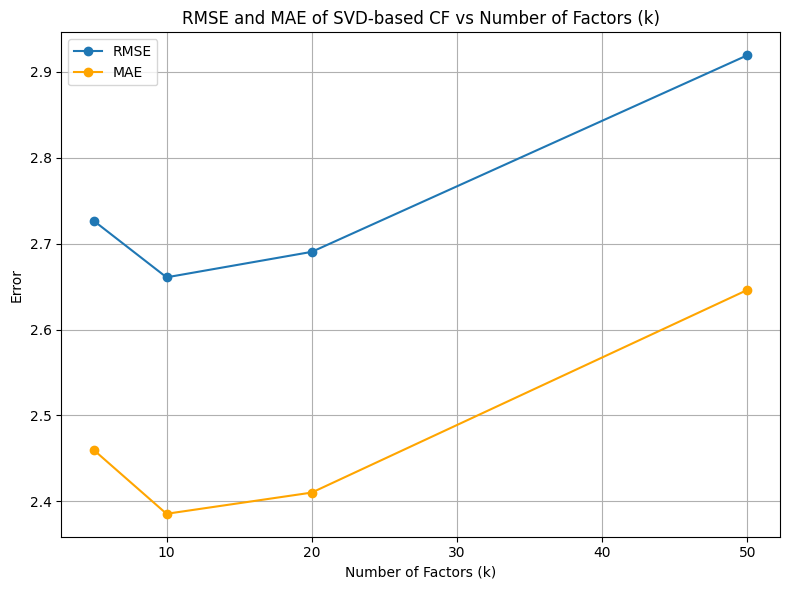

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, rmse_values, marker='o', label='RMSE')
plt.plot(k_values, mae_values, marker='o', label='MAE', color='orange')

plt.title('RMSE and MAE of SVD-based CF vs Number of Factors (k)')
plt.xlabel('Number of Factors (k)')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# 2. Implement ALS-based Collaborative Filtering


The biggest problem of the previous SVD-based method is that our rating matrix has too many missing values which leads to bad performance. So, we will bring some optimization techniques focused on the only filled rating values to improve the quality of our recommendation system.

From this chapter, we will use UV decomposition instead of SVD to implement the new version of collaborative filtering.

So, our final object is to decompose
our rating matrix $ Y $ as follows:

$
Y = U I^T
$

Where:
- $ Y $: (U $\times$ M)
- $ U $: (U $\times$ k)
- $ I^T $: (k $\times$ M)

<center>
<img src="https://drive.google.com/uc?id=1PQuXCS771GQJeTPtj36U2LLGfTBLFwiS" width="800" height="300">
</center>




**Alternating Mnimization** is a widely used optimization method, applicable not only to matrix decomposition but also to various classical machine learning problems, such as Gaussian mixture models. It is particularly useful when it is challenging to optimize multiple parameters simultaneously. Instead, it alternates between fixing one set of parameters and optimizing the others, repeating this process until a local optimum is reached.

**Alternative Least Square (ALS)** is one of the alternating minimization methods.
For matrix decomposition, ALS works as follows:

1. Randomly initialize the matrix $ U $.
2. Given $ U $, compute matrix $ I $ using only the observed entries of $ Y $.
3. Given $ I $, compute $ U $ using only the observed entries of $ Y $.
4. Repeat steps 2 and 3 until convergence.

While ALS does not theoretically guarantee convergence, it generally performs well in practice, delivering strong results in various applications. Moreover, steps 2 and 3 can be shown as **linear regression problems**, which have closed-form solutions. This allows for efficient implementation using existing linear regression libraries, such as NumPy!

**By executing the cell below, you can view the results of ALS for each value of k.**





In [ ]:
import numpy as np
import pandas as pd

class ALS_CF:
    def __init__(self, num_factors=10, reg=0.1, num_iters=10):
        self.num_factors = num_factors
        self.reg = reg
        self.num_iters = num_iters

    def fit(self, ratings):
        self.ratings = ratings
        self.num_users, self.num_items = ratings.shape

        self.user_factors = np.random.rand(self.num_users, self.num_factors)
        self.item_factors = np.random.rand(self.num_items, self.num_factors)

        for _ in range(self.num_iters):
            self.user_factors = self._als_step(self.user_factors, self.item_factors, self.ratings)
            self.item_factors = self._als_step(self.item_factors, self.user_factors, self.ratings.T)

    def _als_step(self, fixed_factors, changing_factors, ratings):
        lambda_eye = self.reg * np.eye(self.num_factors)
        updated_factors = np.zeros_like(fixed_factors)

        for i in range(fixed_factors.shape[0]):
            non_zero_indices = ratings[i, :] > 0
            if np.sum(non_zero_indices) == 0:
                continue

            V = changing_factors[non_zero_indices, :]
            r = ratings[i, non_zero_indices]

            updated_factors[i, :] = np.linalg.solve(V.T @ V + lambda_eye, V.T @ r)

        return updated_factors

    def predict(self):
        return self.user_factors @ self.item_factors.T


def train_test_split(ratings, test_size=0.2):
    test_indices = []
    for user in ratings['user'].unique():
        user_data = ratings[ratings['user'] == user]
        test_indices.extend(user_data.sample(frac=test_size, random_state=42).index)
        test_set = ratings.loc[test_indices]
        train_set = ratings.drop(test_indices)
    return train_set, test_set

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2)
train_matrix = train_ratings.pivot(index='user', columns='movie', values='rating').fillna(0).values

k_values = [10, 50]

print("ALS-based CF Results:")
for num_factors in k_values:
    print(f"Number of Factors (k): {num_factors}")
    als = ALS_CF(num_factors=num_factors, reg=0.1, num_iters=15)
    als.fit(train_matrix)
    predicted_ratings_als = als.predict()

    predictions_als = []
    actuals = []

    for _, row in test_ratings.iterrows():
        user, movie, actual_rating = int(row['user']) - 1, int(row['movie']) - 1, row['rating']
        if user < predicted_ratings_als.shape[0] and movie < predicted_ratings_als.shape[1]:
            predictions_als.append(predicted_ratings_als[user, movie])
            actuals.append(actual_rating)

    rmse_als = sqrt(mean_squared_error(actuals, predictions_als))
    mae_als = mean_absolute_error(actuals, predictions_als)

    print(f"RMSE: {rmse_als:.4f}")
    print(f"MAE: {mae_als:.4f}")
    print()

ALS-based CF Results:
Number of Factors (k): 10
RMSE: 1.2498
MAE: 0.9178

Number of Factors (k): 50
RMSE: 1.6516
MAE: 1.2775



# 3. Implement SGD-based Collaborative Filtering

While alternating least squares (ALS) has several advantages, it also has limitations. As the size of the matrix Y increases, the computational cost grows significantly. In particular, the closed-form solutions computed in steps 2 and 3 are computationally expensive.

Another approach to solving matrix decomposition is **Gradient Descent**, similar to the training process in deep learning. Using this method, the elements of the matrices U and I are initialized randomly. Then, by defining a loss function such as Mean Square Error (MSE), the matrices are optimized using **Gradient Descent or Stochastic Gradient Descent (SGD)**.

The steps for applying SGD in matrix decomposition are as follows:

1. Initialize the matrices $U$ and $I$ randomly.
2. Calculate the loss function for observed entries:  
   $error = Y - U * I^T$.
3. Update $U$ and $I$ iteratively using the gradient of the loss with respect to each matrix element.
4. Repeat the updates until the error converges or a maximum number of iterations is reached.

SGD is known for its ability to train efficiently and converge quickly on many benchmark datasets. Unlike methods that require computing matrix inverses, SGD avoids such operations and leverages GPU acceleration using libraries like PyTorch or TensorFlow, making it a fast and practical choice for matrix decomposition.

A key point to note is that regularization through **weight decay** significantly impacts performance. Both theoretically and experimentally, it is crucial for achieving better optimizations. Therefore, this approach to regularization has been implemented in the current code as well.

**By executing the cell below, you can view the results of SGD for each value of k.**

In [ ]:
class SGD_CF:
    def __init__(self, num_factors=10, learning_rate=0.01, reg=0.1, num_iters=10):
        self.num_factors = num_factors
        self.learning_rate = learning_rate
        self.reg = reg
        self.num_iters = num_iters

    def fit(self, ratings):
        self.ratings = ratings
        self.num_users, self.num_items = ratings.shape

        self.user_factors = np.random.rand(self.num_users, self.num_factors)
        self.item_factors = np.random.rand(self.num_items, self.num_factors)

        for _ in range(self.num_iters):
            for i in range(self.num_users):
                for j in range(self.num_items):
                    if self.ratings[i, j] > 0:
                        error = self.ratings[i, j] - np.dot(self.user_factors[i, :], self.item_factors[j, :])

                        self.user_factors[i, :] += self.learning_rate * (
                            error * self.item_factors[j, :] - self.reg * self.user_factors[i, :]
                        )
                        self.item_factors[j, :] += self.learning_rate * (
                            error * self.user_factors[i, :] - self.reg * self.item_factors[j, :]
                        )

    def predict(self):
        return self.user_factors @ self.item_factors.T

def train_test_split(ratings, test_size=0.2):
    test_indices = []
    for user in ratings['user'].unique():
        user_data = ratings[ratings['user'] == user]
        test_indices.extend(user_data.sample(frac=test_size, random_state=42).index)
        test_set = ratings.loc[test_indices]
        train_set = ratings.drop(test_indices)
    return train_set, test_set

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2)
train_matrix = train_ratings.pivot(index='user', columns='movie', values='rating').fillna(0).values

k_values = [10, 50]

print("SGD-based CF Results:")
for num_factors in k_values:
    print(f"Number of Factors (k): {num_factors}")
    sgd = SGD_CF(num_factors=num_factors, learning_rate=0.01, reg=0.1, num_iters=15)
    sgd.fit(train_matrix)
    predicted_ratings_sgd = sgd.predict()

    predictions_sgd = []
    actuals = []

    for _, row in test_ratings.iterrows():
        user, movie, actual_rating = int(row['user']) - 1, int(row['movie']) - 1, row['rating']
        if user < predicted_ratings_sgd.shape[0] and movie < predicted_ratings_sgd.shape[1]:
            predictions_sgd.append(predicted_ratings_sgd[user, movie])
            actuals.append(actual_rating)

    rmse_sgd = sqrt(mean_squared_error(actuals, predictions_sgd))
    mae_sgd = mean_absolute_error(actuals, predictions_sgd)

    print(f"RMSE: {rmse_sgd:.4f}")
    print(f"MAE: {mae_sgd:.4f}")
    print()


SGD-based CF Results:
Number of Factors (k): 10
RMSE: 0.9955
MAE: 0.7893

Number of Factors (k): 50
RMSE: 1.0561
MAE: 0.8346



# 4. Implement Neural Collaborative Filtering (NCF)

<center>
<img src="https://drive.google.com/uc?id=154OrC1ohx8bhckaSi5pQuuOUdobwdDcD" width="500" height="300">
</center>

**Neural Collaborative Filtering (NCF)** is the simplest extension of matrix factorization using neural networks. The stability and effectiveness of learning matrix factorization through gradient descent, both theoretically and empirically, serve as a foundation for this extension.

While traditional matrix factorization models the interaction between user and item vectors as a simple dot product, NCF replaces the dot product with a multi-layer perceptron (MLP) to enhance expressive power. This approach allows the model to capture more complex relationships between users and items that traditional matrix factorization might miss.

To implement an NCF model, the dimension of the user embedding vector must be specified, which corresponds to the rank in matrix factorization. Like matrix factorization, NCF can be abstracted as follows:

$ y = f(u, i) $

Here, $ f $ represents the neural network function mapping the user and item embeddings $u, i$ to the predicted interaction $ y $.

This approach has the advantage of efficiently processing large-scale datasets with speed and accuracy by utilizing GPU acceleration. In this chapter, the existing process was implemented using PyTorch. The main model is a 3-layer MLP with ReLU activation functions, and the final output is projected to a range between 0 and 1 using a Sigmoid function. For evaluation, the output is rescaled to a range of 1 to 5, which aligns with the test rating scale.


**By executing the cell below, you can view the results of NCF for each value of k.**


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import torch
import torch.nn as nn
import torch.optim as optim

# NCF Implementation using PyTorch
class NCF(nn.Module):
    def __init__(self, num_users, num_items, num_factors):
        super(NCF, self).__init__()

        # Embedding layers for users and items
        self.user_embedding = nn.Embedding(num_users, num_factors)
        self.item_embedding = nn.Embedding(num_items, num_factors)

        # Neural network layers
        self.fc1 = nn.Linear(num_factors * 2, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)

        self.activation = nn.ReLU()
        self.output = nn.Sigmoid()

    def forward(self, user, item):
        user_embedded = self.user_embedding(user)
        item_embedded = self.item_embedding(item)

        # Concatenate user and item embeddings
        x = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through fully connected layers with dropout
        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(self.fc3(x))

        return x

# Prepare data for PyTorch
class NCFDataset(torch.utils.data.Dataset):
    def __init__(self, ratings):
        self.users = torch.tensor(ratings['user'].values, dtype=torch.long)
        self.items = torch.tensor(ratings['movie'].values, dtype=torch.long)
        self.ratings = torch.tensor(ratings['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

# Train-test split for PyTorch
def train_test_split(ratings, test_size=0.2):
    test_indices = []
    for user in ratings['user'].unique():
        user_data = ratings[ratings['user'] == user]
        test_indices.extend(user_data.sample(frac=test_size, random_state=42).index)
    test_set = ratings.loc[test_indices]
    train_set = ratings.drop(test_indices)
    return train_set, test_set

# Prepare data
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings['user'] = ratings['user'] - ratings['user'].min()
ratings['movie'] = ratings['movie'] - ratings['movie'].min()
min_rate, max_rate = ratings['rating'].min(), ratings['rating'].max()
ratings['rating'] = (ratings['rating'] - min_rate) / (max_rate - min_rate)
ratings = ratings.reset_index()
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2)

# Filter test set to include only known users and movies
train_user_set = set(train_ratings['user'])
train_item_set = set(train_ratings['movie'])
test_ratings = test_ratings[
    (test_ratings['user'].isin(train_user_set)) &
    (test_ratings['movie'].isin(train_item_set))
]

num_users = ratings['user'].nunique()
num_items = ratings['movie'].nunique()

# Hyperparameters
learning_rate = 1e-3
weight_decay = 1e-4
batch_size = 64
epochs = 5

k_values = [10, 50]
print("NCF Results:")
for num_factors in k_values:
    print(f"Number of Factors (k): {num_factors}")
    # Initialize model, loss function, and optimizer
    model = NCF(num_users, num_items, num_factors)
    loss_function = nn.MSELoss()  # Use Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Prepare data loaders
    train_dataset = NCFDataset(train_ratings)
    test_dataset = NCFDataset(test_ratings)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for users, items, ratings in train_loader:
            optimizer.zero_grad()
            predictions = model(users, items).squeeze()
            loss = loss_function(predictions, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(ratings)
        train_loss /= len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

    # Evaluation
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for users, items, ratings in test_loader:
            preds = model(users, items).squeeze()
            predictions.extend((preds * (max_rate - min_rate) + min_rate).tolist())
            actuals.extend((ratings * (max_rate - min_rate) + min_rate).tolist())

    rmse_ncf = sqrt(mean_squared_error(actuals, predictions))
    mae_ncf = mean_absolute_error(actuals, predictions)

    print(f"RMSE: {rmse_ncf:.4f}")
    print(f"MAE: {mae_ncf:.4f}")
    print()

NCF Results:
Number of Factors (k): 10
Epoch 1/5, Loss: 0.0779
Epoch 2/5, Loss: 0.0664
Epoch 3/5, Loss: 0.0581
Epoch 4/5, Loss: 0.0558
Epoch 5/5, Loss: 0.0546
RMSE: 0.9351
MAE: 0.7375

Number of Factors (k): 50
Epoch 1/5, Loss: 0.0729
Epoch 2/5, Loss: 0.0620
Epoch 3/5, Loss: 0.0574
Epoch 4/5, Loss: 0.0562
Epoch 5/5, Loss: 0.0553
RMSE: 0.9417
MAE: 0.7500



# 5. Conclusion
<center>
<img src="https://drive.google.com/uc?id=1oIShW7zilGVnAqcQ5tbnSN4FGyDyfIqR" width="500" height="300">
</center>

The table above provides a final summary of the results so far (note that values may vary slightly depending on the seed and development environment). By implementing various methods, we were able to further enhance our recommendation system! One notable insight is that we successfully decomposed the rating matrix of nearly 1,000 users and movies with just k=10.

Collaborative Filtering has evolved as a way to answer the question: **"How can we effectively decompose a matrix into user and item matrices?**" Today, research in this area actively explores leveraging auxiliary user information (e.g., country, age, location, gender) or employing models like Graph Neural Networks (GNNs) to capture complex relationships.


# 6. References

* [Deisenroth, Marc Peter, A. Aldo Faisal, and Cheng Soon Ong. Mathematics for machine learning. Cambridge University Press, 2020](https://mml-book.github.io/book/mml-book.pdf)

* [Beyond Collaborative Filtering: Recommendation Modeling in Hyperconnect AI](https://hyperconnect.github.io/2024/10/21/beyond-collaborative-filtering.html)

* Su, X., & Khoshgoftaar, T. M. (2009). A survey of collaborative filtering techniques. Advances in artificial intelligence, 2009.

* Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix factorization techniques for recommender systems. Computer, 42(8), 30-37.

* Jain, P., Netrapalli, P., & Sanghavi, S. (2013, June). Low-rank matrix completion using alternating minimization. In Proceedings of the forty-fifth annual ACM symposium on Theory of computing (pp. 665-674).

* Lee, J., Kim, S., Lebanon, G., & Singer, Y. (2013, May). Local low-rank matrix approximation. In International conference on machine learning (pp. 82-90). PMLR.

* Yuan, T., Cheng, J., Zhang, X., Qiu, S., & Lu, H. (2014, June). Recommendation by mining multiple user behaviors with group sparsity. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 28, No. 1).

* Bhojanapalli, S., Neyshabur, B., & Srebro, N. (2016). Global optimality of local search for low rank matrix recovery. Advances in Neural Information Processing Systems, 29.

* He, X., Liao, L., Zhang, H., Nie, L., Hu, X., & Chua, T. S. (2017, April). Neural collaborative filtering. In Proceedings of the 26th international conference on world wide web (pp. 173-182).
